# Implementing a pipeline with transformers library

This is the jupyter notebook that I implemented the use of utilizing a model to train on a known dataset.

In [ ]:
#we will import  ready model from transformers
from transformers import pipeline
#we will import image similarity library
 

## Setup I needed, I also created a virtual environment

In [1]:
!pip install transformers datasets faiss-cpu -q

## Load model for computing embeddings of the candidate images

In [2]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "facebook/detr-resnet-50"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

/home/leto/transeyle/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/leto/transeyle/.env/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


## Load candidate subset

In [4]:
from datasets import load_dataset


seed = 42
num_samples = 100
dataset = load_dataset("zh-plus/tiny-imagenet", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

Generating valid split: 100%|██████████| 10000/10000 [00:00<00:00, 186131.42 examples/s]


## Extract embeddings

In [5]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [6]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

100%|██████████| 1/1 [00:00<00:00, 744.46it/s]


Dataset({
    features: ['image', 'label', 'embeddings'],
    num_rows: 100
})

## Load test set for querying

In [8]:
test_ds = load_dataset("zh-plus/tiny-imagenet", split="valid")

## Select a random sample and run the query

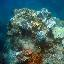

In [9]:
import numpy as np


random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [10]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


scores, retrieved_examples = get_neighbors(query_image)

In [13]:
# Reference:
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion_jax_how_to.ipynb

from PIL import Image


def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

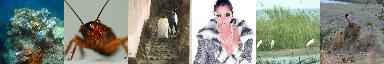

In [14]:
images = [query_image]
images.extend(retrieved_examples["image"])


image_grid(images, 1, len(images))